In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
# from tqdm import

In [2]:
connectivity_min, connectivity_max = 0.1,65
# random_input_span = (1.2,2.8)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 30
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational']
neuron_model = current_models[1]

model_folder_name = neuron_model+'_ensembles'

# Capture related ensembles

In [3]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [4]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1])
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [5]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}

In [6]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_period.txt') ) as file:
                field_period = float( file.readline() )
                field_period_glossary_dict[g][delay].append( field_period )                

            if neuron_model == 'Rotational': #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(field_period_glossary_dict[g][delay])
        if neuron_model == 'Rotational':amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


# Sigma dataframe

In [7]:
sigma_table = pd.DataFrame.from_dict(sigma_glossary_dict)
sigma_table.index.name = 'delay'
sigma_table.columns.name = 'connectivity'
sigma_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.202734,0.200059,0.202081,0.207731,0.218939,0.307464,0.334258,0.345435,0.348795,0.350822
0.07,0.234472,0.239600,0.295911,0.405676,0.426879,0.434726,0.438649,0.437921,0.435216,0.431597
0.09,0.257556,0.373844,0.471879,0.490618,0.495370,0.496952,0.494909,0.489603,0.484637,0.478126
0.11,0.278908,0.498758,0.525286,0.530675,0.532171,0.530002,0.526686,0.519226,0.514384,0.507357
0.13,0.485570,0.551865,0.562950,0.565479,0.563564,0.558400,0.552047,0.548052,0.539585,0.534087
0.15,0.546973,0.583057,0.591887,0.589806,0.585269,0.578951,0.576688,0.569812,0.563680,0.558672
0.17,0.594040,0.616587,0.623262,0.620392,0.611302,0.595251,0.586845,0.580570,0.577762,0.579899
0.19,0.597676,0.616651,0.622720,0.618254,0.615489,0.613002,0.608868,0.605823,0.606176,0.604476
0.21,0.617307,0.632327,0.637840,0.633947,0.628895,0.628847,0.628491,0.630816,0.633060,0.630751


Text(0.5, 1, 'Sigma as an Order parameter')

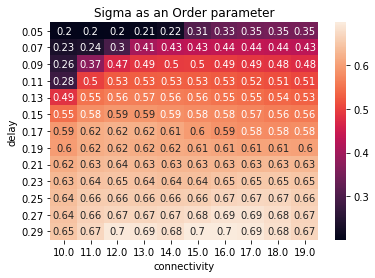

In [12]:
ax_sigma = sns.heatmap(sigma_table, annot=True)
ax_sigma.set_title('Sigma as an Order parameter')

# Field period dataframe

In [9]:
field_period_table = pd.DataFrame.from_dict(field_period_glossary_dict)
field_period_table.index.name = 'delay'
field_period_table.columns.name = 'connectivity'
field_period_table

connectivity,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0
delay,,,,,,,,,,
0.05,0.394479,0.300246,0.210748,0.216691,0.216218,0.220760,0.225991,0.230947,0.236408,0.239521
0.07,0.393002,0.327162,0.261474,0.270288,0.275482,0.283288,0.290276,0.298079,0.302115,0.307692
0.09,0.367383,0.304415,0.315461,0.324675,0.333891,0.342466,0.350877,0.358423,0.273723,0.278983
0.11,0.379883,0.354614,0.369009,0.284271,0.389105,0.400803,0.409836,0.418410,0.426441,0.436681
0.13,0.407177,0.405681,0.418410,0.432909,0.444444,0.456621,0.467290,0.480769,0.374409,0.252525
0.15,0.440529,0.455583,0.469484,0.483092,0.503782,0.512821,0.529101,0.543478,0.560228,0.583095
0.17,0.495244,0.505051,0.520833,0.448673,0.565260,0.855538,0.882353,0.606061,0.623059,0.653595
0.19,0.531930,0.550968,0.571429,0.591716,0.306279,0.632911,0.653595,0.510204,0.353357,0.735294
0.21,0.574713,0.598802,0.468263,0.645161,0.668964,0.694444,0.738017,0.763359,0.793651,0.819672


Text(0.5, 1, 'Field period time')

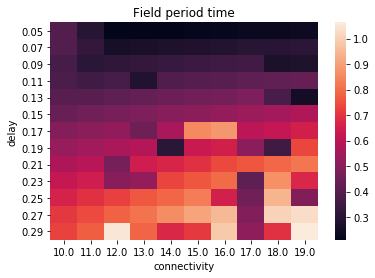

In [10]:
ax_field_period = sns.heatmap(field_period_table, annot=False)
ax_field_period.set_title('Field period time')

# Amin Saman Parameter

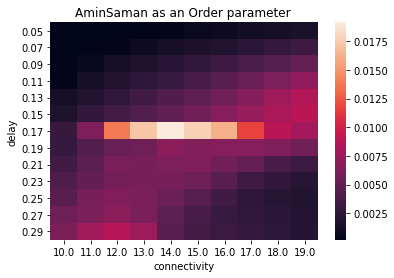

In [11]:
if neuron_model == 'Rotational':
    amin_saman_param_table = pd.DataFrame.from_dict(amin_saman_param_glossary_dict)
    amin_saman_param_table.index.name = 'delay'
    amin_saman_param_table.columns.name = 'connectivity'
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')